In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

In [3]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (15, 15)

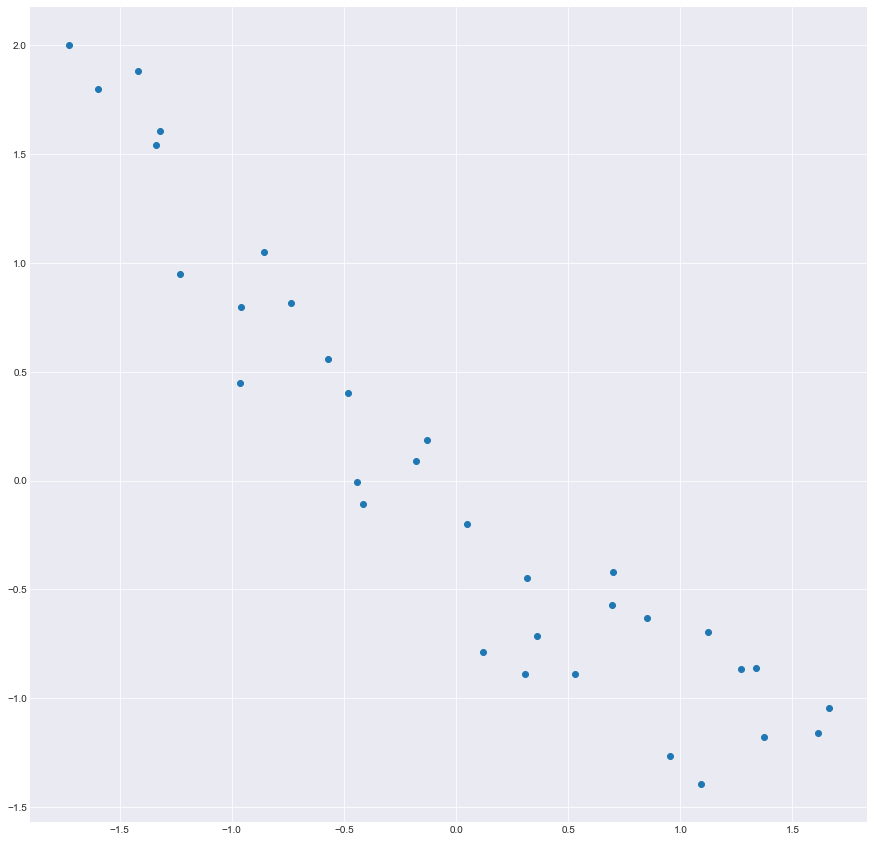

In [4]:
def standardize(xs):
    if len(xs.shape) == 1:
        return (xs - xs.mean()) / xs.std()
    return (xs - xs.mean(axis=1, keepdims=True)) / xs.std(axis=1, keepdims=True)

points = np.loadtxt('../data/dummy.csv')
xs = standardize(points[:, 0])
ys = standardize(points[:, 1])
plt.scatter(xs, ys);

In [5]:
def monomials(xs, order):
    return np.vstack([xs**d for d in range(0, order + 1)]) 

def sample(xs, ys, order):
    xss = monomials(xs, order)
    with pm.Model() as model:
        β = pm.Normal('β', mu=0, sd=10, shape=order + 1)
        ε = pm.HalfNormal('ε', 5)
        μ = pm.math.dot(β, xss)
        y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=ys)
        return (pm.sample(2000), model)

In [6]:
(traces, models) = list(zip(*[sample(xs, ys, order=d) for d in range(1, 6)]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 1791.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1338.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 856.06draws/s] 
The acceptance probability does not match the target. It is 0.8821511402307407, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:08<00:00, 614.03draws/s]
Auto-assigning NU

In [7]:
def plot_curve(trace, bounds, steps=100):
    (lo, hi) = bounds
    (_, count) = trace['β'].shape
    xs = np.linspace(lo, hi, steps)
    xss = monomials(xs, count - 1)
    β = trace['β'].mean(axis=0)
    ys = np.dot(β, xss)
    plt.plot(xs, ys, label=f'degree {count - 1}')    
    
def plot_all_curves(traces, bounds, steps=100):
    bounds = (xs.min(), xs.max())
    for trace in traces:
        plot_curve(trace, bounds)
        plt.legend()

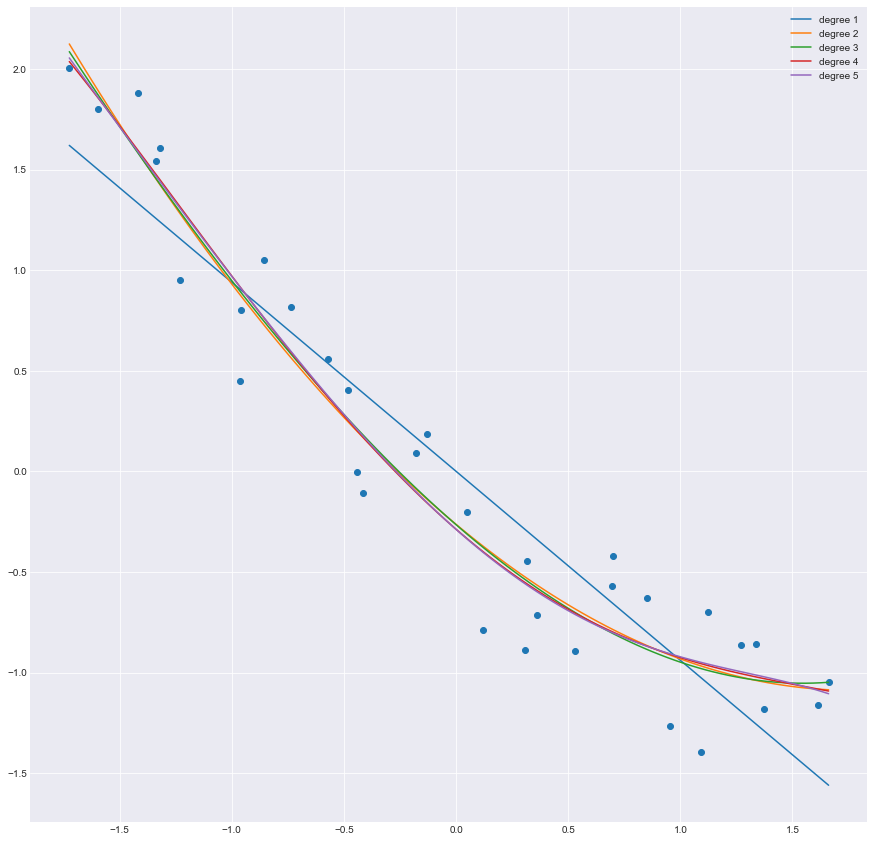

In [8]:
plt.scatter(xs, ys)
plot_all_curves(traces, (xs.min(), xs.max()))

In [9]:
pp_samples = [pm.sample_posterior_predictive(trace, 2000, model=model)['y_pred']
              for (trace, model) in zip(traces, models)]

100%|██████████| 2000/2000 [00:01<00:00, 1535.99it/s]


In [10]:
def iqr(xs, axis=0):
    return np.subtract(*np.percentile(xs, [75, 25], axis=axis))

def plot_stats(ys, pp_samples, statistics=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
    statistics = statistics or [np.mean, iqr]
    for (i, fn) in enumerate(statistics):
        t_ys = fn(ys)
        ax[i].axvline(t_ys, 0, 1, color='k', ls='--')
        for (j, pp) in enumerate(pp_samples):
            t_pp = fn(pp, axis=1)
            p_value = np.mean(t_pp >= t_ys)
            az.plot_kde(
                t_pp,
                plot_kwargs={'color': f'C{j + 1}'},
                label=f'p-value {p_value:.2f}, degree {j + 1}',
                ax=ax[i])

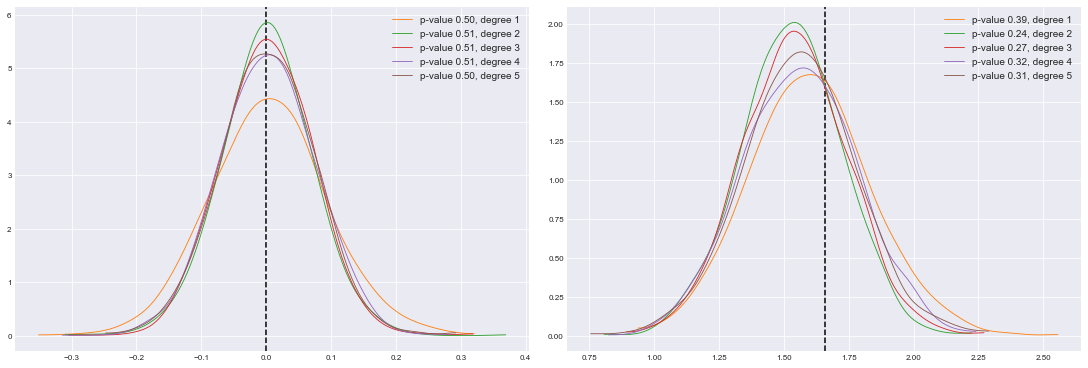

In [130]:
plot_stats(ys, pp_samples)

In [12]:
waics = [az.waic(trace) for trace in traces]

/home/bart/.pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


In [29]:
comparison = az.compare(dict(zip([f'degree {i + 1}' for i in range(len(traces))], traces)), method='BB-pseudo-BMA')
display(comparison)

/home/bart/.pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
degree 2,9.05611,2.63171,0,0.606083,4.67465,0,0,deviance
degree 3,10.7138,3.23966,1.65773,0.268256,4.9864,0.724446,0,deviance
degree 4,12.9673,4.20099,3.91121,0.0949629,4.69614,1.20099,1,deviance
degree 5,15.4128,4.89013,6.35667,0.030015,5.14665,1.46069,1,deviance
degree 1,28.5652,2.38084,19.5091,0.000682866,4.72531,5.34173,0,deviance


In [32]:
pp_averaged = pm.sample_posterior_predictive_w(traces, samples=1000, models=models, weights=comparison.weight)

100%|██████████| 1000/1000 [00:00<00:00, 1620.06it/s]


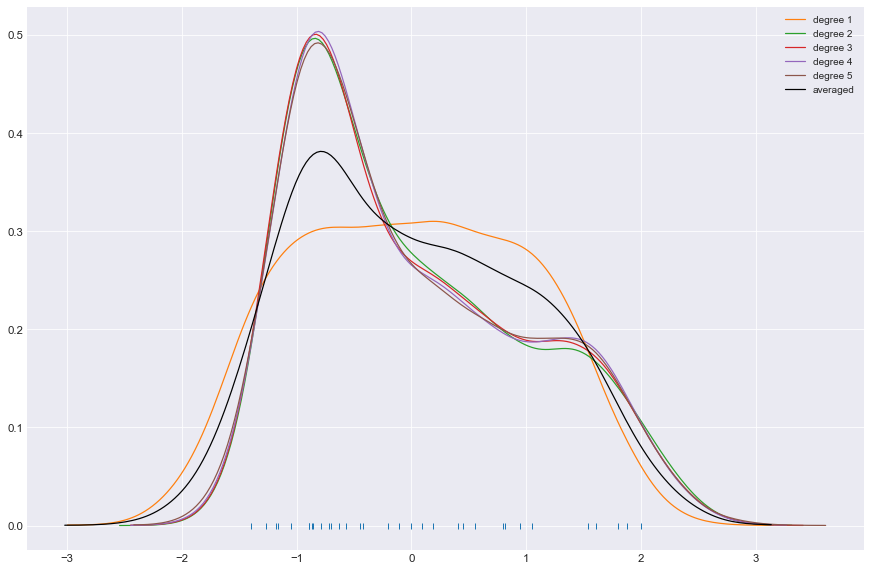

In [41]:
_, ax = plt.subplots(figsize=(15, 10))
for (i, pp) in enumerate(pp_samples):
    az.plot_kde(pp, plot_kwargs={'color': f'C{i + 1}'}, label=f'degree {i + 1}', ax=ax)
az.plot_kde(pp_averaged['y_pred'], plot_kwargs={'color': 'black'}, label='averaged', ax=ax)
plt.plot(ys, np.zeros_like(ys), '|', label='observations')